# 07_dimensionality_reduction

    # 07_dimensionality_reduction
        ## 7-1. Setup
        ## 7-2. 차원 축소 - PCA(1)
        ## 7-3. 차원의 저주
        ## 7-4. 차원 축소를 위한 접근 방법
            ### 7-4-1. 투영(Projection)
            ### 7-4-2. 매니폴드 학습 (Manifold Learning)
        ## 7-5. PCA
            ### 7-5-1. 분산 보존
            ### 7-5-2. 주성분
            ### 7-5-3. d차원으로 투영하기
            ### 7-5-4. 사이킷럿에서 사용하기
            ### 7-5-5. 적절한 차원 수 선택하기
            ### 7-5-6. 압축을 위한 PCA
            ### 7-5-7. 점진적 PCA
            ### 7-5-8. Randomized PCA
            ### 7-5-9. Time complexity
        ## 7-5. 커널 PCA
            ### 7-5-1. 커널 선택과 하이퍼파라미터 튜닝
        ## 7-6. Locally Linear Embedding
        ## 7-7. 다른 차원 축소 기법
            ### 7-7-1.  MDS, Isomap and t-SNE

## 7-1 Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 7-2. 차원 축소 - PCA(1)

* 대부분 실무에서 분석하는 데이터는 매우 많은 특성(feature)들을 가지고 있음.  
* 이러한 데이터를 가지고 머신러닝 알고리즘을 적용해 문제를 해결하려고 한다면, 데이터의 차원이 크기 때문에 학습 속도가 느릴 뿐만아니라 성능 또한 좋지 않을 가능성이 큼  

## 7-3. 차원의 저주

머신러닝에서 데이터 셋의 특성(feature)가 많아지면, 각 특성인 하나의 차원(dimension) 또한 증가하게 됨  
데이터의 차원이 증가할 수록 데이터 공간의 부피가 기하 급수적으로 증가하기 때문에, 데이터의 밀도는 차원이 증가할 수록 희소(sparse)해짐  
아래의 그림은 데이터의 차원이 증가할수록 각 영역(region)에 포함되는 데이터의 개수를 나타냄.(출처: jermwatt's blog)  
그림에서 알 수 있듯이 차원이 증가할 수록 데이터의 밀도가 희소해지는것을 알 수 있음  

데이터의 차원이 증가할수록 데이터 포인트 간의 거리 또한 증가하게 됨  
이러한 데이터를 이용해 머신러닝 알고리즘을 학습 하게되면 모델이 복잡해지게 됨 -> 오버피팅(overfitting) 위험이 커짐  
이러한 차원의 저주를 해결하기 위한 방법 중 하나는 데이터의 밀도가 높아질 때까지 학습 데이터셋의 크기를 늘리는 것임 -> 하지만, 데이터셋의 크기에 비해 차원은 기하급수적으로 커지기 때문에 거의 불가능  

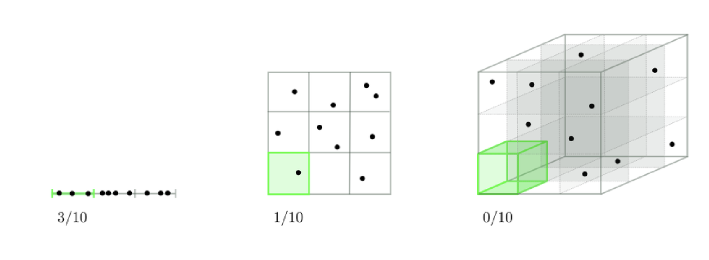

In [2]:
import matplotlib.image as mpimg

dim_img = mpimg.imread("./images/dimension.png")
plt.figure(figsize=(12, 6))
plt.imshow(dim_img)
plt.axis("off")
plt.show()

## 7-4. 차원 축소를 위한 접근 방법
### 7-4-1. 투영(Projection)

* 대부분의 실전문제는 훈련 샘플이 모든 차원에 걸쳐 균일하게 퍼져 있지 않음  
* 많은 특성은 거의 변화가 없는 반면, 다른 특성들은 서로 강하게 연관되어 있음  
* 결과적으로 모든 훈련 샘플이 사실 고차원 공간 안의 저차원 **부분 공간**(subspace)에 놓여 있음  

> **dataset 준비**

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

> **PCA using SVD decomposition**

Note: the `svd()` function returns `U`, `s` and `Vt`, where `Vt` is equal to $\mathbf{V}^T$, the transpose of the matrix $\mathbf{V}$. Earlier versions of the book mistakenly said that it returned `V` instead of `Vt`. Also, Equation 8-1 should actually contain $\mathbf{V}$ instead of $\mathbf{V}^T$, like this:

$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

m, n = X.shape
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

X2D_using_svd = X2D

> **PCA using Scikit-Learn**

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

X3D_inv = pca.inverse_transform(X2D)
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

> **Utility class to draw 3D arrows (copied from http://stackoverflow.com/questions/11140163)**

In [6]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

> **x와 y의 함수로 평면을 표현**

In [7]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

> **3D dataset**으로 그림을 그리면 다음과 같음

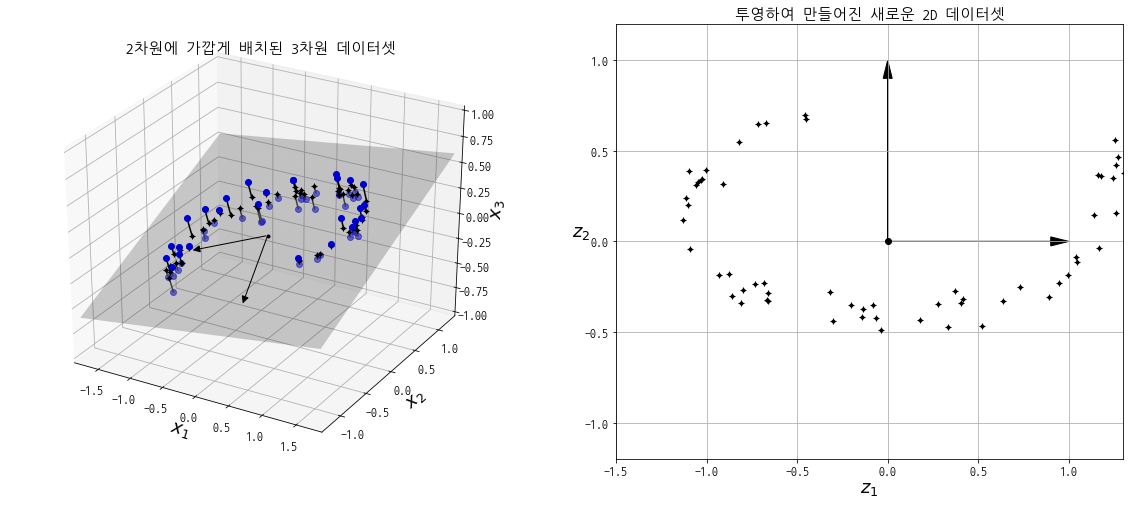

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.title("2차원에 가깝게 배치된 3차원 데이터셋")

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

ax = fig.add_subplot(122, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
plt.title("투영하여 만들어진 새로운 2D 데이터셋")

plt.show()

왼쪽 그림은 모든 훈련 샘플이 거의 평면 형태로 놓여 있음.  
이 것이 고차원(3D) 공간에 있는 저차원(2D) 부분 공간임. 여기서 모든 훈련 샘플을 이 부분 공간에 수직으로(즉, 샘플과 평면사이의 가장 짧은 직선을 따라) 투영하면 오른쪽 그림같은 2D데이터셋을 얻음  
각 축은 $z_{1}$과 $z_{2}$에 대응됨  

In [9]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

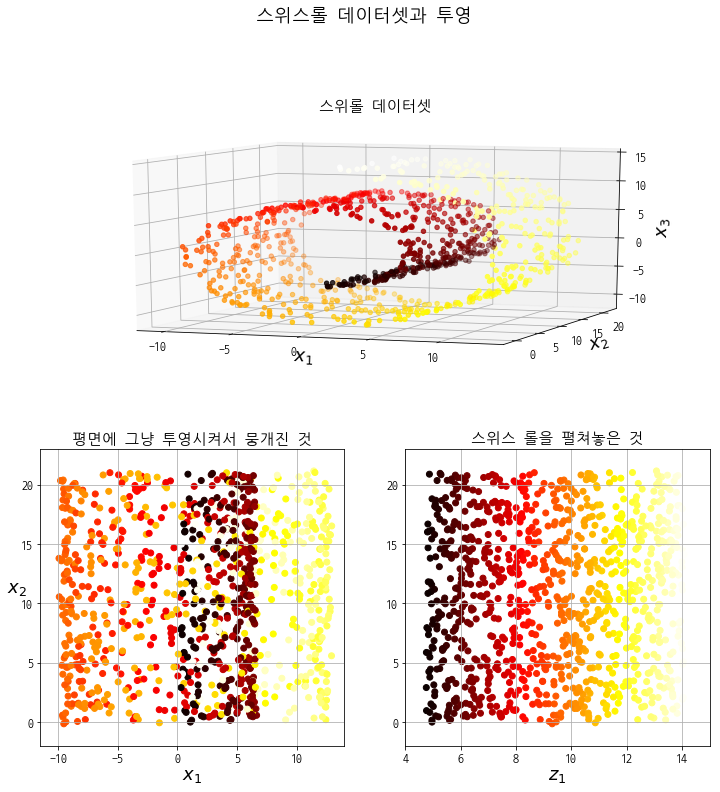

In [10]:
axes = [-11.5, 14, -2, 23, -12, 15]
plt.figure(figsize=(12, 12)).suptitle("스위스롤 데이터셋과 투영", fontsize=18)
# fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.title("스위롤 데이터셋")

# plt.subplot(325)
plt.subplot(223)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.title("평면에 그냥 투영시켜서 뭉개진 것")

# plt.subplot(326)
plt.subplot(224)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)
plt.title("스위스 롤을 펼쳐놓은 것")

plt.show()

* 스위스 롤은 2D 매니폴드의 한 예임  
* 2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D 모양임  
* 일반적으로 d차원 매니폴드는 국부적으로 d차원 초평으로 보일 수 있는 n차원 공간의 일부(d < n)  
* 스위스 롤의 경우에는 d=2이고, n=3, 3차원으로 말려 있음

### 7-4-2. 매니폴드 학습 (Manifold Learning)

* 많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 **매니폴드**를 모델링하는 식으로 작동  
* 이를 **매니폴드 학습**이라고 하며 이는 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 **매니폴드 가정**, **매니폴드 가설**에 근거함  

---

* MNIST 데이터셋으로 생각해보면 전체 손글씨 숫자 이미지는 어느 정도 비슷함  
* 선으로 연결되어 있고 경계는 흰색이고 어느 정도 중앙에 있음  
* 무작위로 생성된 이미지라면 그중 아주 적은 일부만 손글씨 숫자처럼 보임  
* 숫자 이미지를 만들 때 가능한 자유도는 아무 이미지나 생성할 때의 자유도보다 훨씬 낮음  
* 이런 제약은 데이터셋을 저차원의 매니폴드로 압축할 수 있음  

---

* 매니폴드 가정은 종종 암묵적으로 다른 가정과 병행됨  
* 바로 처리해야 할 작업이 저차원의 매니폴드 공간에 표현되면 더 간단해질 것이라는 가정  

---

> 이 과정은 아래 코드로 구현함

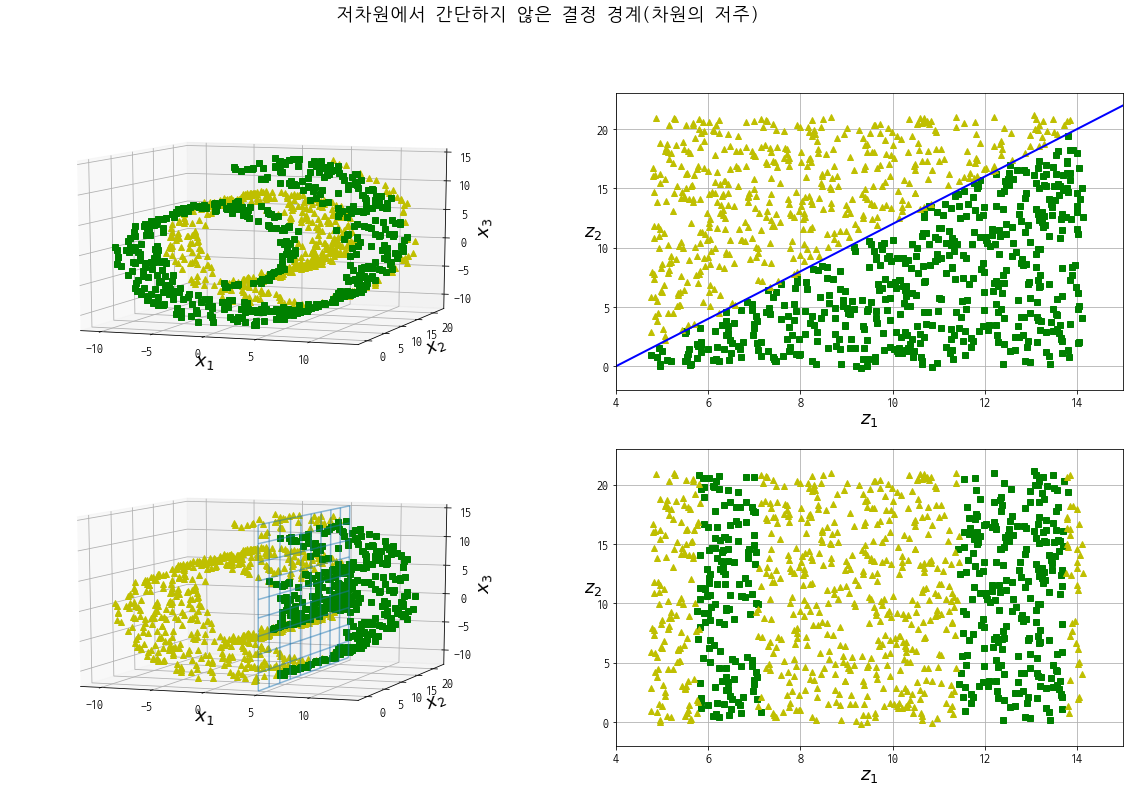

In [11]:
from matplotlib import gridspec

plt.figure(figsize=(20, 12)).suptitle("저차원에서 간단하지 않은 결정 경계(차원의 저주)", fontsize=18)

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

# fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(223, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# plt.show()

# fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(224)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

# plt.show()

# fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(221, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# plt.show()

# fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(222)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

* 바로 처리해야 할 작업이 저차원의 매니폴드 공간에 표현되면 더 간단해질 것이라는 가정하에 위 그림과 같이 표현됨  
* 첫 번째 행에서는 스위스 롤이 2개의 클래스로 나뉘어 있음  
    * 3D(왼쪽)에서는 결정 경계가 매우 복잡하지만 펼쳐진 매니폴드 공간인 2D(오른쪽)에서는 결정 경계가 단순한 직선  

---

* 2번째 행의 경우에는 결정 경계가 $x_{1}=5$에 놓여 있음  
* 이 결정 경계는 3D 공간에서는 매우 단순함(수직 평면)  
* 하지만 펼쳐진 매니폴드에서는 결정 경계가 더 복잡해짐(4개의 독립된 수직선)  

---

* 모델을 훈련시키기 전에 훈련 세트의 차원을 감소시키면 훈련 속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는 것이 아님  

## 7-5. PCA

**Principal Component Analysis(PCA)**은 가장 인기 있는 차원 축소 알고리즘  
먼저 데이터에 가장 가까원 초평면(hyperplane)을 정의한 다음, 데이터를 이 평면에 투영시킴  

### 7-5-1. 분산 보존

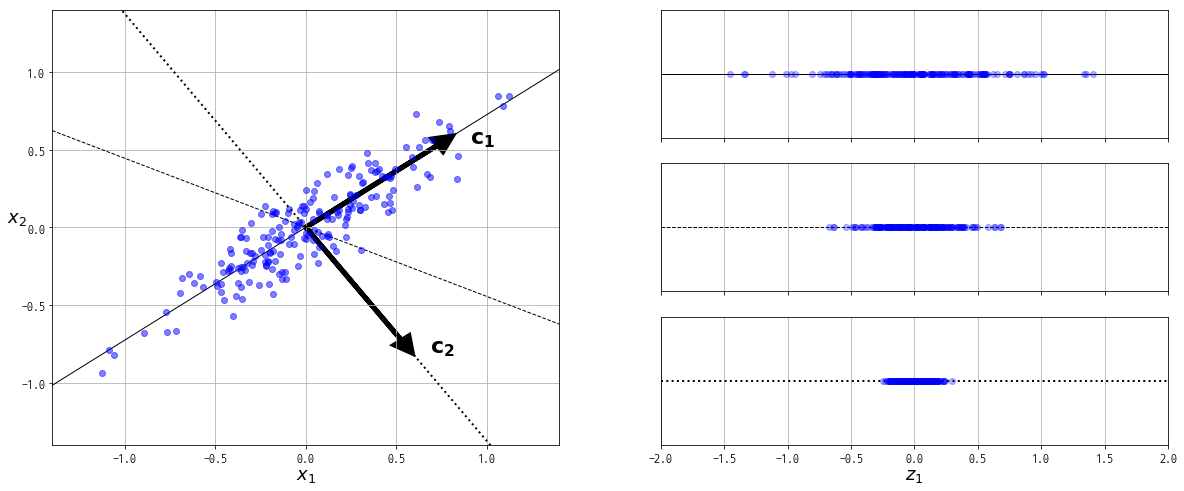

In [12]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(20, 8))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

* 왼쪽 그래프는 간단한 2D 데이터셋이 3개의 축(일차원 초평면)과 함께 표현되어 있음  
* 오른쪽 그래프는 데이터셋이 각 축에 투영된 결과  
* 여기서 볼 수 있는 실선이 투영된 것은 분산을 최대로 보존하는 반면, 점선에 투영된 것은 분산을 매우 적게 유지  
* 가운데의 파선에 투영된 것은 분산을 중간 정도로 유지함  
* 다른 방향으로 투영하는 것보다 분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적으로 보임  

> 이는 원본 데이터셋과 투영된 것 아이의 평균 제곱 거리를 최소화하는 축  

### 7-5-2. 주성분

*  PCA는 훈련 세트에서 분산이 최대인 축을 찾음  
* 1번째 PC는 $c_{1}$이고 2번째 PC는 $c_{2}$임, 또한 세 번째 PC는 평면에 수직  

> 주성분의 방향은 일정하지 않음  
훈련 세트를 조금 섞은 다음 PCA를 적용하면 새로운 PC중 일부가 원래 PC와 반대 방향일 수가 있음 -> 그러나 일반적으로 같은 축에 놓여 있음

Note: the `svd()` function returns `U`, `s` and `Vt`, where `Vt` is equal to $\mathbf{V}^T$, the transpose of the matrix $\mathbf{V}$. Earlier versions of the book mistakenly said that it returned `V` instead of `Vt`. Also, Equation should actually contain $\mathbf{V}$ instead of $\mathbf{V}^T$, like this:


$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$


* 다음 파이썬 코드는 numpy의 svd() 함수를 사용해 훈련 세트의 모든 주성분을 구한 후 처음 2개의 PC를 추출  

```python
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]
```

### 7-5-3. d차원으로 투영하기

* 주성분을 모두 추출했다면 처음 d개의 중성분으로 정의한 초평면에 투영하여 데이터셋의 차원을 d차원으로 축소시킬 수 있음  
* 이 초평면은 분산을 가능한 한 최대로 보존하는 투영임을 보장  

```python
m, n = X.shape
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

X2D_using_svd = X2D
```

### 7-5-4. scikit-learn

* scikit-learn의 PCA모델은 앞서 한 것처럼 SVD 분해 방법을 사용하여 구현  
* PCA모델을 사용해 데이터셋의 차원을 2로 줄이는 코드(scikit-learn의 PCA모델은 자동으로 데이터를 중앙에 맞춤)  

```python
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
```

* PCA 변환기를 데이터셋에 학습시키고 나면 components_ 변수를 사용해 주성분을 확인할 수 있음  
* 이 변수에는 주성분이 행 벡터로 포함되어 있으므로 첫 번째 주성분은 `pca.components_.T[:, 0]`  

### 7-5-5. 적절한 차원 수 선택하기

> MNIST compression

In [13]:
from six.moves import urllib
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [14]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [16]:
d

154

In [17]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

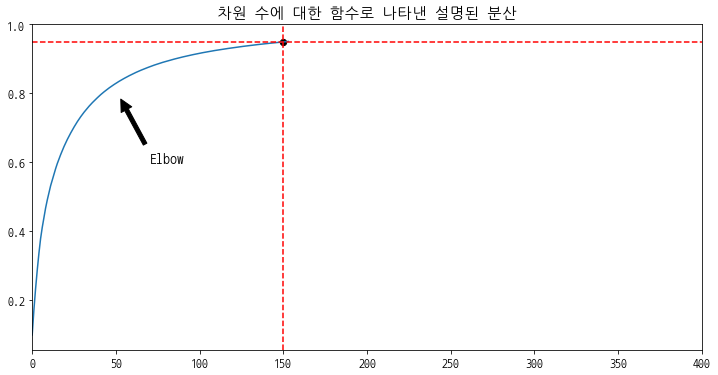

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(cumsum)
plt.axhline(y=0.95, color="r", linestyle="--")
plt.axvline(x=150, color="r", linestyle="--")
plt.scatter(150, 0.95, s=40, c="k")
plt.annotate("Elbow", xy=(51, 0.8), xytext=(70, 0.6), fontsize=14, arrowprops=dict(facecolor="black", shrink=0.1))
plt.xlim(0, 400)
plt.title("차원 수에 대한 함수로 나타낸 설명된 분산")
plt.show()

In [19]:
pca.n_components_

154

In [20]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295708

### 7-5-6. 압축을 위한 PCA

차원을 축소하고 난 후에는 훈련 세트의 크기가 줄어듬 

In [21]:
from six.moves import urllib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

* 각 샘플은 원래의 784개 특성이 아니라 15개 정도만 가지고 있음  
* 대부분의 분산은 유지되었지만 데이터셋은 원본크기의 150/784 $\approx$ 19%정도가 됨  
* 이는 상당한 압축률이고 (SVM)같은 분류 알고리즘의 속도를 높일 수 있음  

* 또한 압축된 데이터셋에 PCA 투영의 변환을 반대로 적용하여 784개의 차원으로 되돌릴 수도 있지만 5% 분산정도를 잃어 버렸기 때문에 원본 데이터셋을 얻을 수는 없음  
* 원본데이터와 재구성된 데이터 사이의 평균 제곱거리를 **재구성 오차**라고 함  

In [22]:
pca = PCA(n_components = 0.95) ## 분산 95% 유지
X_reduced = pca.fit_transform(X_train) ## 압축
X_recovered = pca.inverse_transform(X_reduced) ## 복원
X_reduced_pca = X_reduced

In [23]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

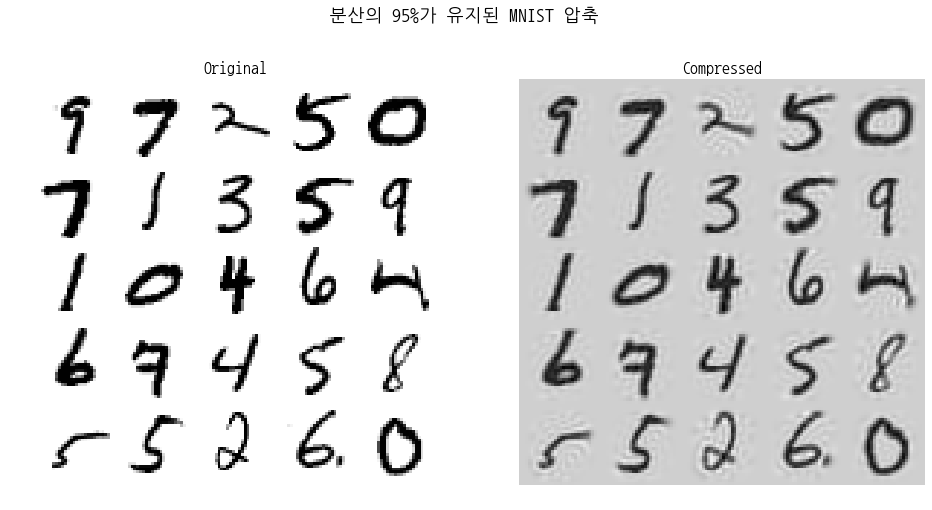

In [24]:
plt.figure(figsize=(16, 8)).suptitle("분산의 95%가 유지된 MNIST 압축", fontsize=18)
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

plt.show()

### 7-5-7. 점진적 PCA

* PCA 구현의 문제는 Singular Value Decomposition, SVD)알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야함  
* **IPCA(Incremental PCA)** 알고리즘은 훈련 세트르르 미니배치로 나눈뒤 IPCA 알고리즘에 한 번에 하나씩 주입  

> data load

```python
from six.moves import urllib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)
```

In [25]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100

inc_pca = IncrementalPCA(n_components=154) # 분산 95% 유지
for X_batch in np.array_split(X_train, n_batches):    
    print("#", end="")
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

####################################################################################################

In [26]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

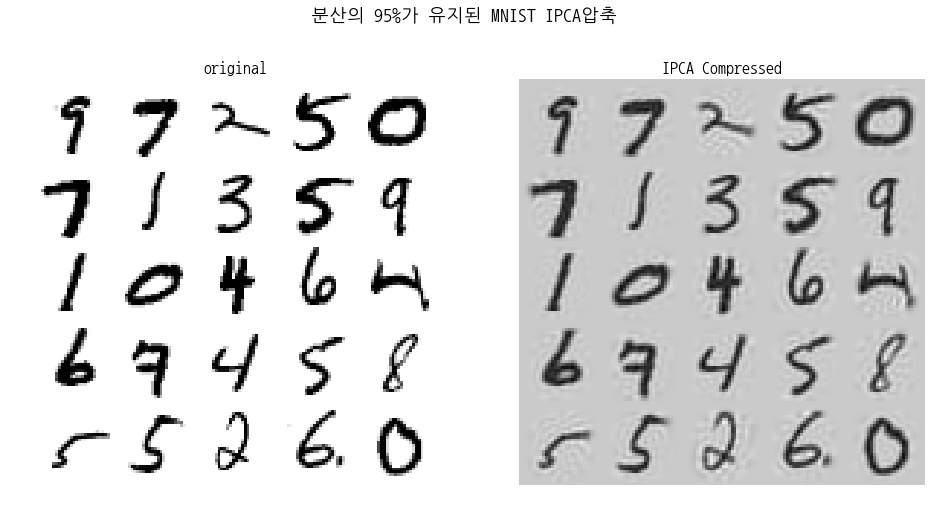

In [27]:
plt.figure(figsize=(16, 8)).suptitle("분산의 95%가 유지된 MNIST IPCA압축", fontsize=18)
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.title("IPCA Compressed", fontsize=16)
plt.show()

In [28]:
X_reduced_inc_pca = X_reduced

일반적인 PCA와 IPCA의 평균을 비교해보면 같음

In [29]:
np.allclose(pca.mean_, inc_pca.mean_)

True

* 그러나 결과는 동일하지 않음
* IPCA는 대략적으로 좋은 솔루션이지만 완벽하지 않음

In [30]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

### 7-5-8. Randomized PCA  

* PCA의 또 다른 옵션으로 Randomized PCA가 있음  
* 이 방식은 확률적인 알고리즘으로, 첫 $d$개의 주성분에 대한 근사값을 빠르게 찾음  

In [31]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [32]:
X_recovered_inc_pca = rnd_pca.inverse_transform(X_reduced)

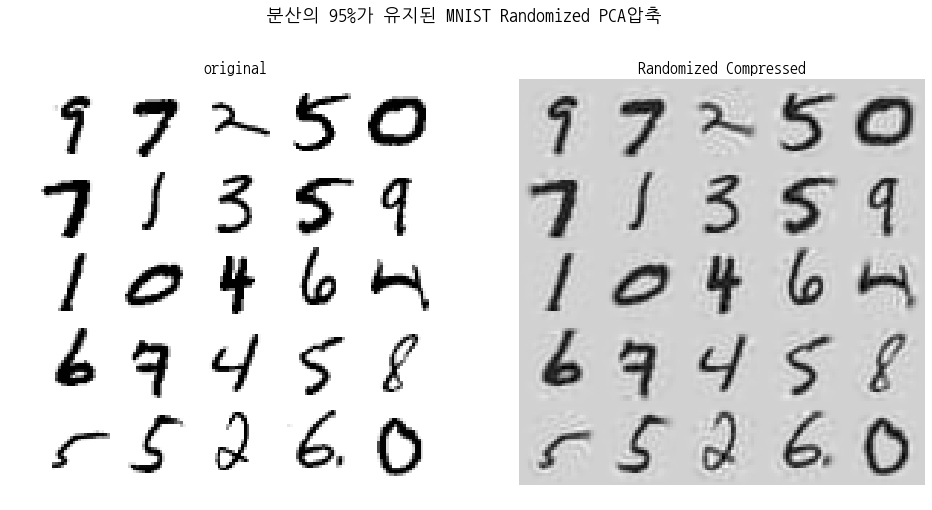

In [33]:
plt.figure(figsize=(16, 8)).suptitle("분산의 95%가 유지된 MNIST Randomized PCA압축", fontsize=18)
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.title("Randomized Compressed", fontsize=16)
plt.show()

### 7-5-9. Time complexity


regular PCA, Icremental PCA, and Randomized PCA의 계산복잡도(시간)을 n_components에 따라 측정해보면 다음과 같음

> n_components에 따른 시간 비교

In [34]:
import time

names = ["Regular PCA", "Incremental PCA", "Randomized PCA"]
for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in zip (names, (regular_pca, inc_pca, rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    Regular PCA: 1.9 seconds
    Incremental PCA: 18.1 seconds
    Randomized PCA: 1.5 seconds
n_components = 10
    Regular PCA: 2.0 seconds
    Incremental PCA: 21.4 seconds
    Randomized PCA: 2.2 seconds
n_components = 154
    Regular PCA: 7.3 seconds
    Incremental PCA: 28.5 seconds
    Randomized PCA: 6.0 seconds


> **Regular PCA**와 **Randomized PCA**에서 다른 사이즈의 데이터셋(행의 갯수)에 대한 시간 복잡도  

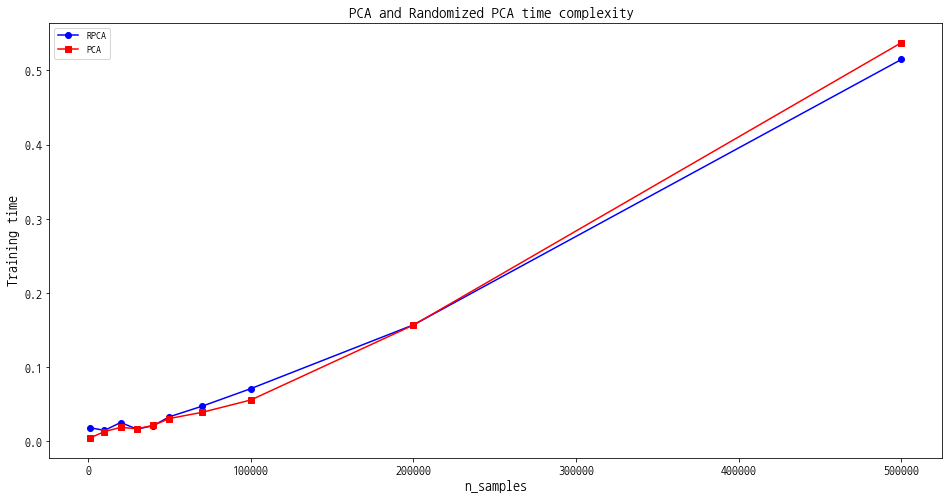

In [35]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)
    
plt.figure(figsize=(16, 8))
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")
plt.show()

> **Regular PCA**와 **Randomized PCA**에서 다른 사이즈의 데이터셋(행=2000, 열의 갯수의 변화)에 대한 시간 복잡도  

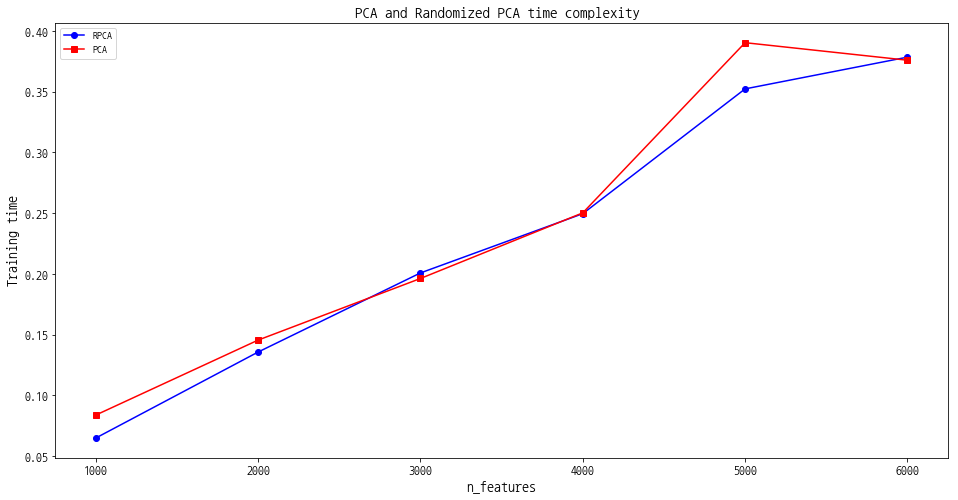

In [36]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.figure(figsize=(16, 8))
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")
plt.show()

## 7-5. 커널 PCA
* 고차원 특성 공간에서의 선형 결정 경계는 **원본 공간**에서는 복잡한 비선형 결정 경계에 해당함  
* 같은 기법을 PCA에 적용하여 비선형 투영으로의 차원 축소가 가능 -> **kernel PCA**  
* **투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때 유용**  

In [37]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [38]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

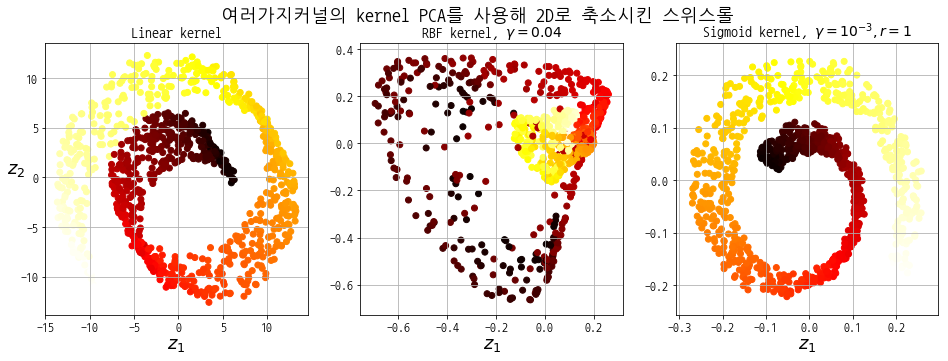

In [39]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(16, 5)).suptitle("여러가지커널의 kernel PCA를 사용해 2D로 축소시킨 스위스롤", fontsize=18)
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### 7-5-1. 커널 선택과 하이퍼파라미터 튜닝
* kernel PCA는 비지도 학습이기 때문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없음  
* 차원 축소는 지도 학습의 전처리 단계로 활용되므로 그리드 탐색을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선택할 수 있음

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRe...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

> 가장 좋은 커널과 하이퍼 파라미터는 best_params_변수에 저장

In [41]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


* 축소된 공간에 있는 샘플에 대해 Linear PCA를 연전 시키면 재구성된 데이터 포인트는 원본 공간이 아닌 특성 공간에 놓이게됨  
* 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트를 찾을 수 있음(pre-image)  
* 원상을 얻게 되면 원본 샘플과 제곱 거리를 측정할 수 있으며 재구성 원상의 오차를 최소화하는 커널과 하이퍼파라미터를 선택할 수 있음  

> 재구성 원상(pre-image)를 구하는 방법

In [42]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [43]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766125

## 7-6. Locally Linear Embedding

* LLE는 **nonlinear dimensionality reduction(NLDR)**기술임  
* PCA와 다른점은 Projection(투영)에 의존하지 않는 매니폴드 학습  

---


1. 먼저 각 훈련 샘플이 가장 가까운 이웃(closet neighbor)에 얼마나 선형적으로 연관되어 있는지 측정  
2. 국부적인 관계가 가장 잘 보존되는 훈련 세트의 저차원 표현을 찾음  
    noise가 너무 많지 않은 경우 꼬인 매니폴드를 펼치는데 잘 작동  
    
--- 

**LLE의 작동 방식**  

1. 알고리즘이 각 훈련 샘플 $x^{(i)}$에 대해 가장 가까운 $k$개의 샘플을 찾음  
2. 이웃에 대한 선형 함수로 $x^{(i)}$와 $\sum^{m}_{j=1}{w_{i,j}x^{(j)}}$ 사이의 제곱거리가 최소가되는 $w_{ij}$를 찾음($x^{(j)}$가 $x^{(i)}$의 가장 가까운 $k$개 이웃 중 하나가 아닐 경우에는 $w_{ij}=0$)  

In [44]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [45]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

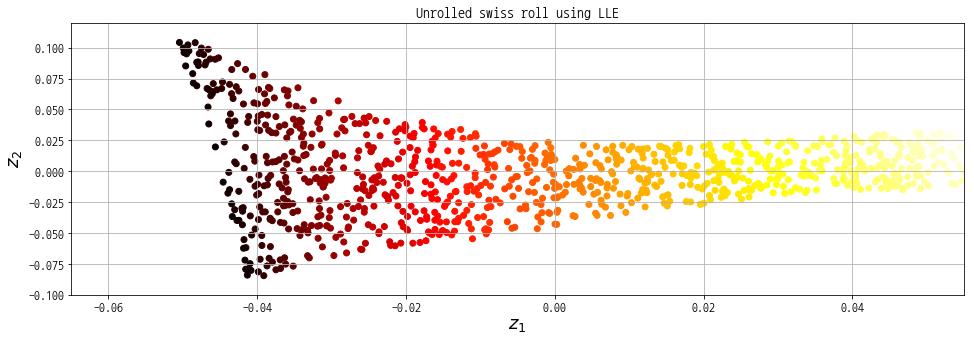

In [46]:
plt.figure(figsize=(16, 5))
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

* LocallyLinearEmbedding을 사용해 스위스 롤을 펼침  
* 지역적으로 샘플 간 거리가 잘 보존되어있음

## 7-7. 다른 차원 축소 기법

### 7-7-1.  MDS, Isomap and t-SNE

* Multidimensional Scaling(MDS)은 샘플 간의 거리를 보존하면서 차원을 축소  
* losmap은 각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만듬 -> 샘플 간의 geodesic distance를 유지하면서 차원을 축소  
    * geodesic distance: 두 노드 사이의 최단 경로를 이루는 노드의 수
* t-SNE(t-Distributed Stochastic Neighbor Embedding)는 비슷한 샘플은 가까이 비슷하지 않은 샘플은 멀리 떨어지도록 차원을 축소  
    * 주로 시각화에 많이 사용되며, 고차원 공간에 있는 샘플의 군집을 시각화할 때 사용  
* Linear Discriminant Analysis(LDA)는 분류 알고리즘이며 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습  
    * projection을 통해 가능한 한 클래스를 멀리 떨어지게 유지시키므로 SVM 분류기 같은 다른 분류 알고리즘을 적용하기 전에 차원을 축소하는 것이 좋음

In [47]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/home/ururu/.conda/envs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


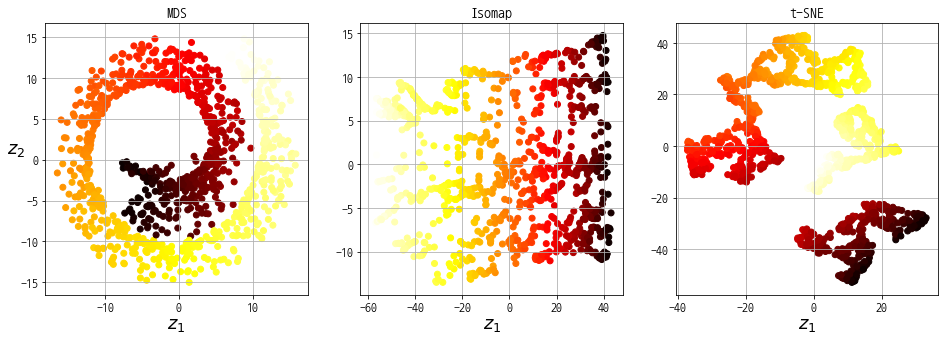

In [50]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(16, 5))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()